## Example. Estimating the risk of tumor in a group of rats

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [4]:
rat_tumor = np.loadtxt('data/rat_tumor_data.txt', skiprows=3)

In [5]:
# If you can use bash
!cat data/rat_tumor_data.txt | head

# Rat tumor data from Tarone (1982).  Data from Table 5.1 of Bayesian Data Analysis.

y N  
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 


As you can see, the first column of `rat_tumor` is $y$ and the second column is $N$.

In [6]:
print('The shape of rat_tumor is {}'.format(rat_tumor.shape))

The shape of rat_tumor is (71, 2)


We construct the model.

In [7]:
with pm.Model() as model_1:
    
    alpha = pm.Uniform('alpha', lower=0, upper=10)
    beta = pm.Uniform('beta', lower=0, upper=30)
        
    theta = pm.Beta('theta', alpha, beta, shape=rat_tumor.shape[0])
    
    y = pm.Binomial('y', n=rat_tumor[:, 1], p=theta, observed=rat_tumor[:, 0])

In [8]:
model_1.check_test_point()

alpha_interval__     -1.39
beta_interval__      -1.39
theta_logodds__     -19.60
y                  -219.84
Name: Log-probability of test_point, dtype: float64

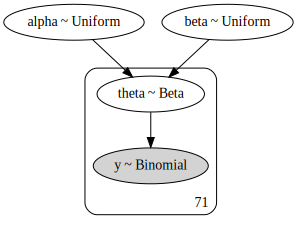

In [9]:
pm.model_to_graphviz(model_1)

In [10]:
with model_1:
    trace_1 = pm.sample(draws=5_000, tune=15_000, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]
Sampling 4 chains: 100%|██████████| 80000/80000 [02:40<00:00, 499.27draws/s]
The acceptance probability does not match the target. It is 0.808790376889786, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


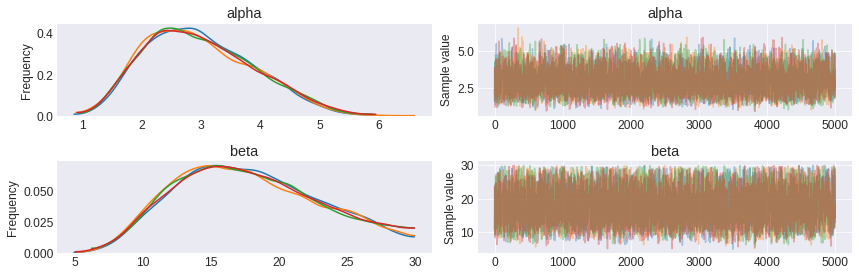

In [11]:
pm.traceplot(trace_1, varnames=['alpha', 'beta']);

In [12]:
pm.summary(trace_1, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.979874,0.901778,0.014996,1.415182,4.740034,3378.963435,1.000089
beta,17.889988,5.262522,0.085057,9.157899,28.612270,3627.288412,1.000142


The posterior plot of `alpha` and `beta`.

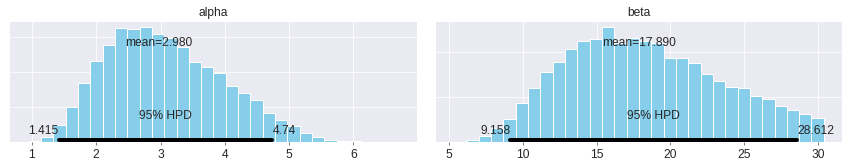

In [13]:
pm.plot_posterior(trace_1, varnames=['alpha', 'beta']);

The next plots are a contour plot and a scatter plot.

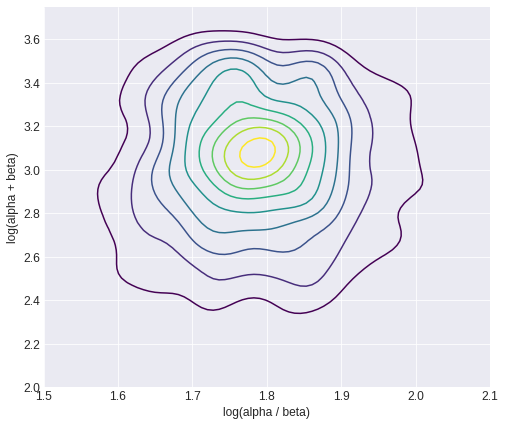

In [36]:
begi = 15_000

alpha_trunc = trace_1['beta'][begi: begi + 1000]
beta_trunc = trace_1['alpha'][begi: begi + 1000]

fig, ax = plt.subplots(figsize=(8, 7))
sns.kdeplot(np.log(alpha_trunc /  beta_trunc), np.log(alpha_trunc + beta_trunc),
            cmap=plt.cm.viridis, n_levels=10, ax=ax)
ax.set_xlim(1.5, 2.1)
ax.set_ylim(2, 3.75)
ax.set_xlabel('log(alpha / beta)')
ax.set_ylabel('log(alpha + beta)');

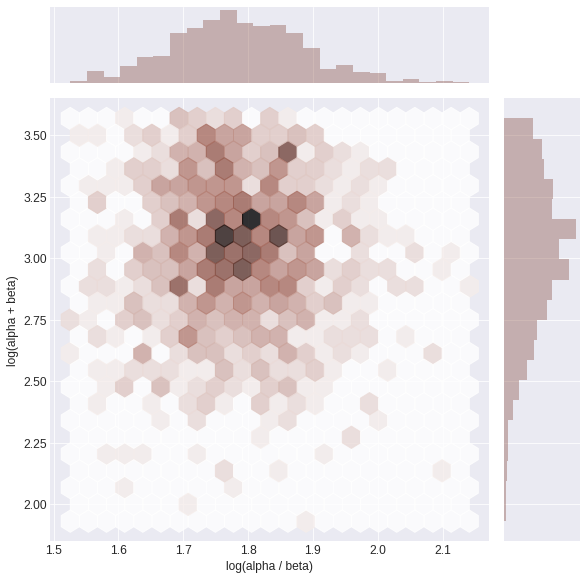

In [47]:
g = sns.jointplot(np.log(alpha_trunc /  beta_trunc), np.log(alpha_trunc + beta_trunc),
             alpha=0.8, color='C5', kind='hex', height=8)
g.set_axis_labels('log(alpha / beta)', 'log(alpha + beta)');

Now, we draw 1000 samples for `theta` from the posterior distribution.

In [127]:
post_theta = pm.sample_ppc(trace_1, samples=1000, model=model_1, vars=[theta], progressbar=False)

Posterior medians and 95% highest posterior density of rat tumor rates, $\theta_j$ (plotted vs. observed tumor rates $y_j / n_j$).

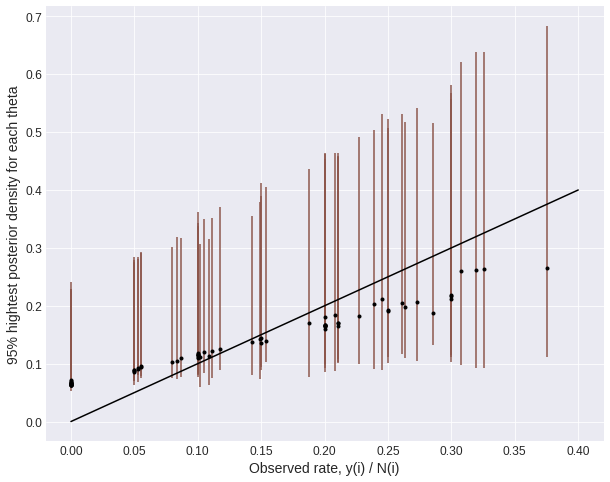

In [128]:
median_theta = []

for i in range(post_theta['theta'].shape[1]):
    median_theta.append(np.median(post_theta['theta'][:, i]))

error_up = []
error_down = []

for i in range(post_theta['theta'].shape[1]):
    a, b = pm.hpd(post_theta['theta'][:, i], alpha=0.05)
    error_up.append(b)
    error_down.append(a)
    
plt.figure(figsize=(10,8))
plt.errorbar(rat_tumor[:, 0] / rat_tumor[:, 1], median_theta, fmt='.',
            yerr=[error_down, error_up], ecolor='C5', markerfacecolor='k', mec='k',
            errorevery=1)
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10),
        color='k')
plt.xlabel('Observed rate, y(i) / N(i)', fontsize=14)
plt.ylabel('95% hightest posterior density for each theta', fontsize=14);